----
# VGG-16 Fine Tuning using Real World Data
-----

### Summary:
This notebook focuses on fine-tuning the pre-trained VGG-16 model using real world images captured using Teachable Machine. The goal is to enhance performance on real-world data. 

### Data Overview:
- **Dataset:** Real World images captured using Teachable Machine
- **Number of Samples:** Approximately 300 images per letter
- **Image Dimensions:** To load images to be 64x64
 
### Notebook Overview:

- **Data Loading:**
    - Load the Real Dataset using keras
    - Split data into training and validation datasets.
    - Scale data

- **Training the VGG Model:**
    - Load base VGG model
    - Compile the model with loss function and optimiser.
    - Train the VGG model on the training data and validate its performance on the validation dataset.

- **Model Evaluation:**
    - Evaluate the accuracy and performance metrics of the trained VGG model on the validation dataset.
    - Analyse the model's performance using a confusion matrix and visualise misclassifications.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import joblib
import math
import seaborn as sns


## Data Loading
---

In [17]:
directory = '../../data/my_imgs/real_world_imgs/'
my_imgs = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True, 
    seed=1
)

Found 7866 files belonging to 24 classes.


In [18]:
train_data, val_data = keras.utils.split_dataset(my_imgs, right_size= 0.2)

In [24]:
for images, _ in train_data:
    images /=255

In [25]:
for images, _ in val_data:
    images /=255

## Fine-Tuning of VGG
---

In [26]:
# load the base VGG model
fine_tuned_vgg = load_model('../../model/my_files/my_VGG_model.h5')

In [27]:
# only to unfreeze the last years of the base_vgg_model
for layer in fine_tuned_vgg.layers[2:]:
    print(layer)
    layer.trainable = True

In [28]:
# recompile the model
fine_tuned_vgg.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [29]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                           verbose=1)

In [30]:
history = fine_tuned_vgg.fit(train_data,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_data = val_data,
                        callbacks=[early_stop])

Epoch 1/20
197/197 [==============================] - 179s 905ms/step - loss: 17.3320 - accuracy: 0.8215 - val_loss: 0.3911 - val_accuracy: 0.9619
Epoch 2/20
197/197 [==============================] - 175s 889ms/step - loss: 0.1865 - accuracy: 0.9820 - val_loss: 0.0808 - val_accuracy: 0.9866
Epoch 3/20
197/197 [==============================] - 177s 900ms/step - loss: 0.0458 - accuracy: 0.9946 - val_loss: 0.0834 - val_accuracy: 0.9898
Epoch 4/20
197/197 [==============================] - 178s 904ms/step - loss: 0.0199 - accuracy: 0.9971 - val_loss: 0.0735 - val_accuracy: 0.9886
Epoch 5/20
197/197 [==============================] - 175s 888ms/step - loss: 0.0179 - accuracy: 0.9960 - val_loss: 0.1453 - val_accuracy: 0.9879
Epoch 6/20
197/197 [==============================] - 171s 871ms/step - loss: 0.0725 - accuracy: 0.9936 - val_loss: 0.0670 - val_accuracy: 0.9930
Epoch 7/20
197/197 [==============================] - 174s 884ms/step - loss: 0.0581 - accuracy: 0.9925 - val_loss: 0.1880 

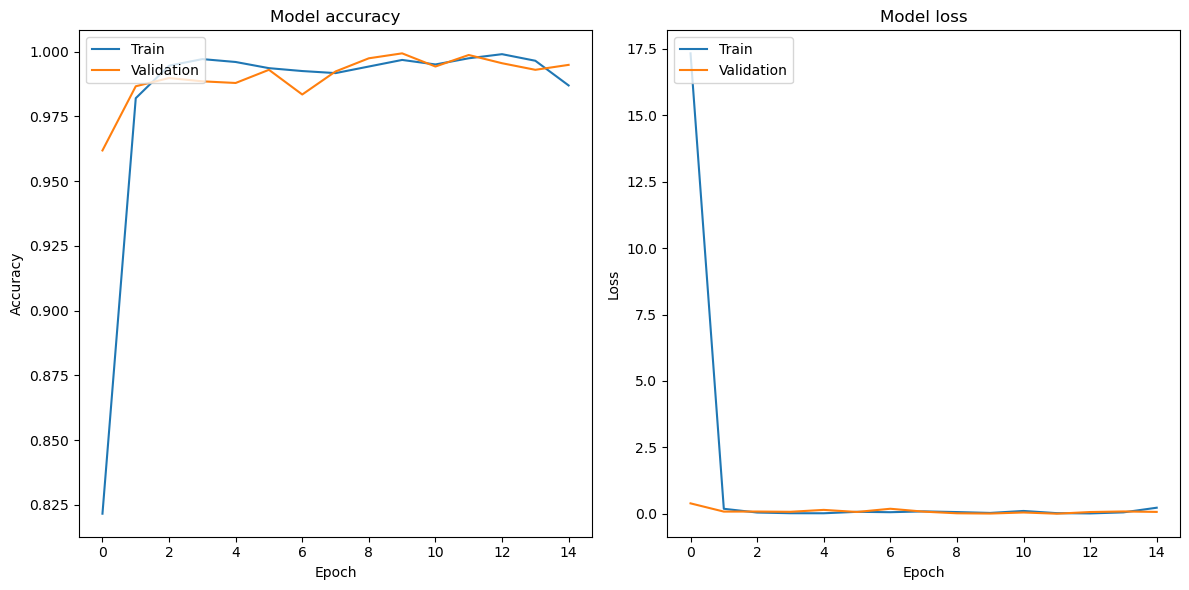

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


**Comment:**

As the number of epochs increases, the VGG begins to converge resulting in improved accuravy and lower loss.

The training and loss both improve dramatically after the first epoch. Perhaps this is becasue the VGG has leveraged its learnt weights and successfully applied this to the dataset.

In [32]:
train_loss, train_acc= fine_tuned_vgg.evaluate(train_data)
print('Train accuracy:', train_acc)

197/197 [==============================] - 136s 691ms/step - loss: 0.0749 - accuracy: 0.9968
Train accuracy: 0.9968218803405762


In [33]:
print(f'Fine-tuned VGG model Training Score: {round(train_acc*100,4)}')

Fine-tuned VGG model Training Score: 99.6822


In [100]:
val_loss, val_acc= fine_tuned_vgg.evaluate(val_data)
print('Validation accuracy:', val_acc)

50/50 [==============================] - 16s 314ms/step - loss: 0.0694 - accuracy: 0.9949
Validation accuracy: 0.994914174079895


In [37]:
print(f'Fine-tuned VGG model Validation Score: {round(val_acc*100,4)}')

Fine-tuned VGG model Validation Score: 99.4914


In [38]:
fine_tuned_vgg.save('../../model/my_models/VGG_fine_tuned.h5')

## Model Evaluation
----

In [39]:
fine_tuned_vgg = load_model('../../model/my_models/VGG_fine_tuned.h5')

In [97]:
# getting actual labels and images from directory
labels = [] # required for confusion matrix
images = [] # required for visualising misclassifs
for imgs, actual_labels in val_data:
    # using extend to iterate and append each element to labels
    labels.extend(actual_labels.numpy())
    images.extend(imgs.numpy().astype(int))

images = np.array(images)

### Confusion Matrix

In [42]:
pred_y = np.argmax(fine_tuned_vgg.predict(val_data), axis=1)

50/50 [==============================] - 38s 749ms/step


In [44]:
conf_matrix = confusion_matrix(labels, pred_y)

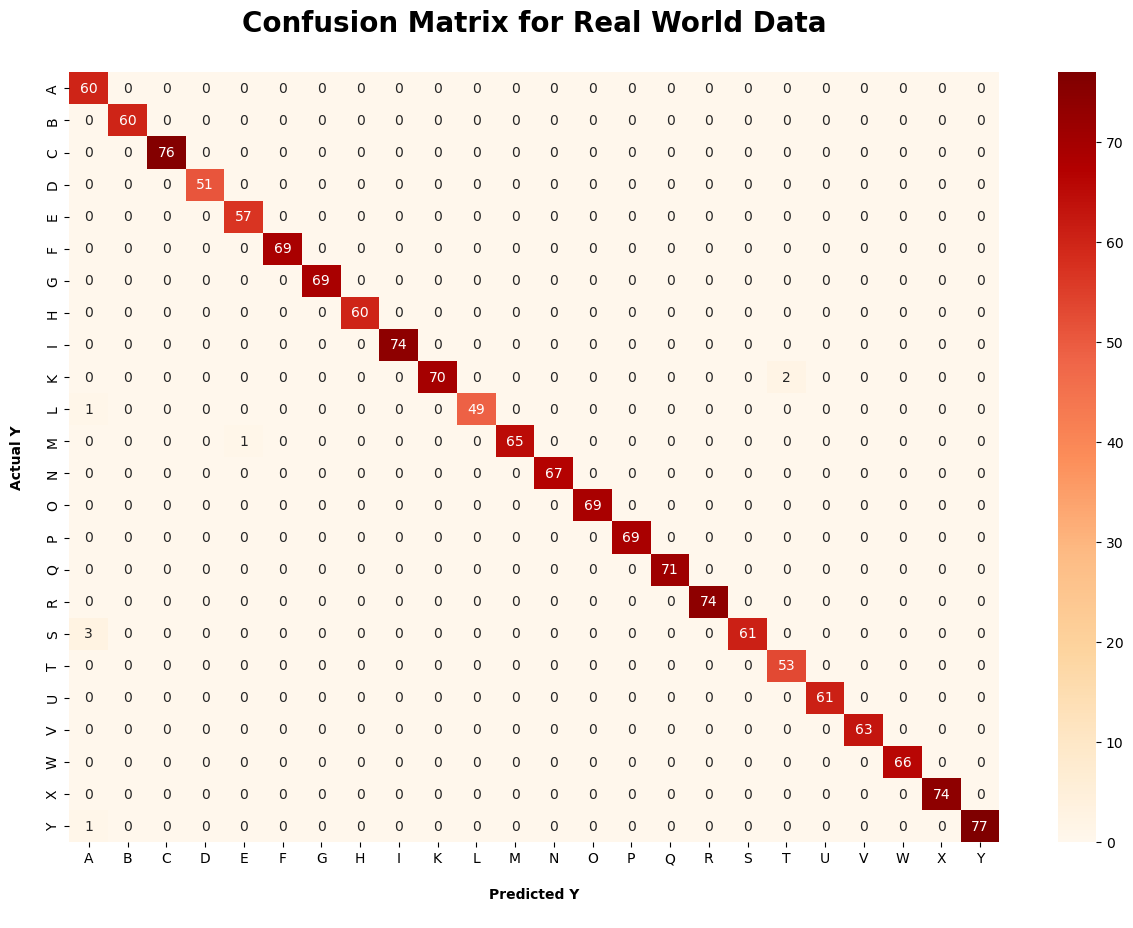

In [53]:
plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix

sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd')# -> fmt = d casting values to int
plt.title('Confusion Matrix for Real World Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(my_imgs.class_names))], my_imgs.class_names)
plt.yticks([y + 0.5 for y in range(len(my_imgs.class_names))], my_imgs.class_names)
plt.show()

### Visualising Misclassifications

In [54]:
incorrect_photos = (labels != pred_y)

In [57]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

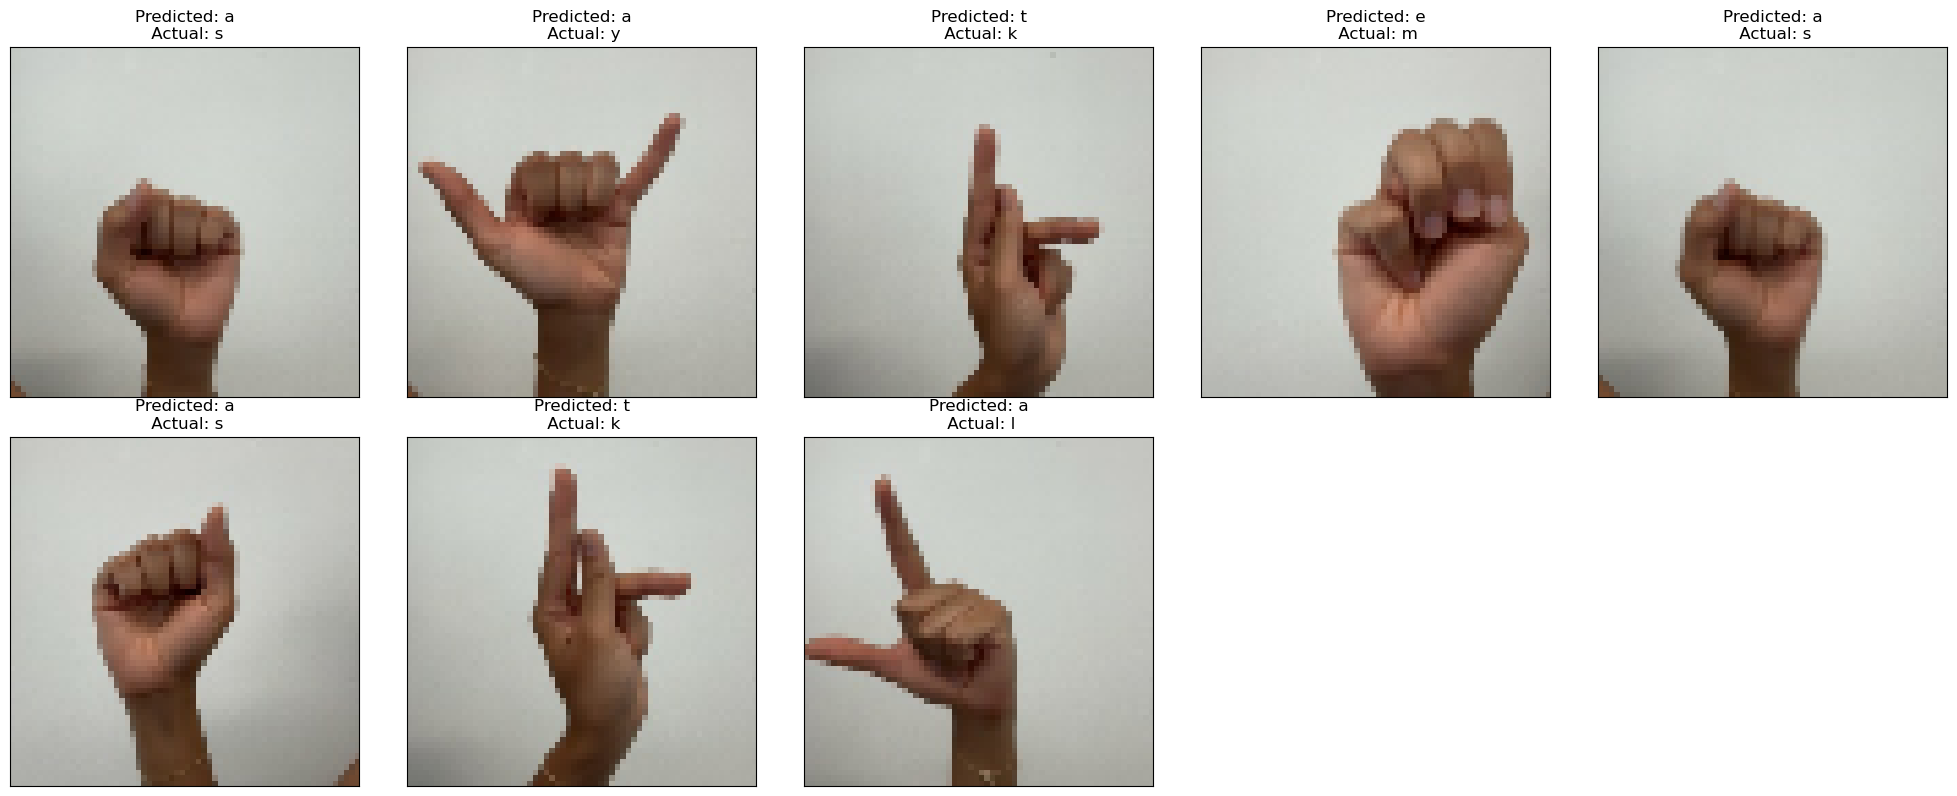

In [99]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

fig, axes = plt.subplots(rows,5, figsize=(20, 4*rows))

ax = axes.flatten()

if num_photos == 0:
    print('There are no misclassifications to show!')
else:

    for i, ax in enumerate(axes.flatten()):
        if i < num_photos:
            ax.imshow(images[incorrect_photos][i].astype(int))

            # Get predicted label
            p = pred_y[incorrect_photos][i]
            prediction = alphabet[p]

            # Get actual label
            a = np.array(labels)[incorrect_photos][i]
            actual = alphabet[a.astype(np.int32)]

            # Set the title of the subplot
            ax.set_title(f"Predicted: {prediction}\n Actual: {actual}")

            # Hide the x and y ticks to make
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)  # Delete unused subplots           

plt.tight_layout()
plt.show()

**Plot Description:**

When taking pictures on Teachable Machine I was purposely adding in varaition by moving my hand. The purpose of this was to make sure the model was more robust when it comes to predicting letters. This is as I am planning to use this model to take in live data and predict a letter.

Looking at the mislcassifications most are sue to the augmentation I applies such as turning my hand inwards/outwards as well as closer/further from the camera. The misclassifications are few and the real test for this model would be on real live data captured. 

## Conclusion
-----

|                  | VGG Model     | VGG with Augmented Data | VGG Fine-Tuned |
|------------------|---------------|-------------------------|----------------|
| Train Score      | 99.98         | 93.70                   | 99.68          |
| Validation Score | 99.83         | 98.98                   | 99.49          |

The fine-tuned VGG model is slightly lower than the base VGG model, this may be as data used to do the top up training had some augmentation.

The validation score of the fine-tuned model is also lower suggesting that the process of fine-tuning did not imporve the models ability to generalise. This could be as I only used 300 images for each class. In the future, I will try to do the top up training again but this time include more images with less augmentation.

To conclude, VGG has outperformed the other models adn so I will be using this model in my steamlit app to do live real time predictions.